# WebDataset Brain Volume Viewer


This notebook inspects a structprep-generated WebDataset shard and visualizes the 16-slice brain volume together with the binary mask overlay.

**Instructions**
- Ensure shards live under `ADNI_wds` or update `SHARD_DIR` in the selection cell.
- Adjust `SHARD_INDEX` to choose which shard to open.
- Run the remaining cells to load the sample and plot all 16 slices plus the mask overlays.


In [15]:
from pathlib import Path
import tarfile
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.rcParams["figure.dpi"] = 120


In [21]:
def find_shard_dir(dirname: str = "ADNI_wds") -> Path:
    """Search the current path and its parents for the WebDataset directory."""
    start = Path.cwd().resolve()
    for base in [start, *start.parents]:
        candidate = base / dirname
        if candidate.exists() and any(candidate.glob("*.tar")):
            return candidate
    raise FileNotFoundError(
        f"Could not find a '{dirname}' directory with .tar shards; set SHARD_DIR manually."
    )

def load_sample(shard_path: Path, index: int = 0):
    """Load a single NPZ sample from a WebDataset shard."""
    with tarfile.open(shard_path, "r") as tar:
        members = [member for member in tar.getmembers() if member.isfile()]
        if not members:
            raise ValueError(f"No .npz payloads found in {shard_path.name}")
        if index >= len(members):
            raise IndexError(
                f"Sample index {index} out of range; shard holds {len(members)} entries"
            )
        member = members[index]
        with tar.extractfile(member) as fh:
            arrays = np.load(fh, allow_pickle=True)
            volume = arrays["volume"]
            mask = arrays["mask"]
            meta = arrays["meta"][()]
    return member.name, volume, mask, meta


In [22]:
try:
    SHARD_DIR = find_shard_dir()
    shards = sorted(SHARD_DIR.glob("*.tar"))
except FileNotFoundError as exc:
    print(exc)
    SHARD_DIR = Path("/path/to/ADNI_wds")
    shards = []

if not shards:
    print("No shard files detected. Update SHARD_DIR above and rerun this cell.")
else:
    for idx, shard in enumerate(shards):
        print(f"[{idx}] {shard.name}")
    SHARD_INDEX = 0  # change this to pick a different shard
    SHARD_PATH = shards[SHARD_INDEX]
    print(f"Selected shard: {SHARD_PATH}")


[0] ADNI_001.tar
Selected shard: /home/mihirneal/ADNI_wds/ADNI_001.tar


In [23]:
if not shards:
    raise RuntimeError("No shards available. Set SHARD_DIR and rerun the previous cell.")

sample_name, volume, mask, metadata = load_sample(SHARD_PATH)
print(f"Loaded sample: {sample_name}")
print(f"Volume shape: {volume.shape}, dtype: {volume.dtype}")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
print("Metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")


Loaded sample: sub-305S6845_ses-20210114_T1w_space-sesTarget_desc-norm_space-iso1mm_desc-train.slices.npz
Volume shape: (16, 256, 256), dtype: float32
Mask shape: (16, 256, 256), dtype: uint8
Metadata:
  input_volume: /home/mihirneal/ADNI_struct/sub-305S6845/ses-20210114/anat/final/sub-305S6845_ses-20210114_T1w_space-sesTarget_desc-norm_space-iso1mm_desc-train.nii.gz
  input_mask: /home/mihirneal/ADNI_struct/sub-305S6845/ses-20210114/anat/final/sub-305S6845_ses-20210114_desc-brain_mask_space-iso1mm.nii.gz
  indices: [87, 94, 101, 108, 115, 122, 129, 136, 143, 150, 157, 164, 171, 178, 185, 193]
  coverage_per_slice: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004998518852517009, 0.0018327903235331178, 

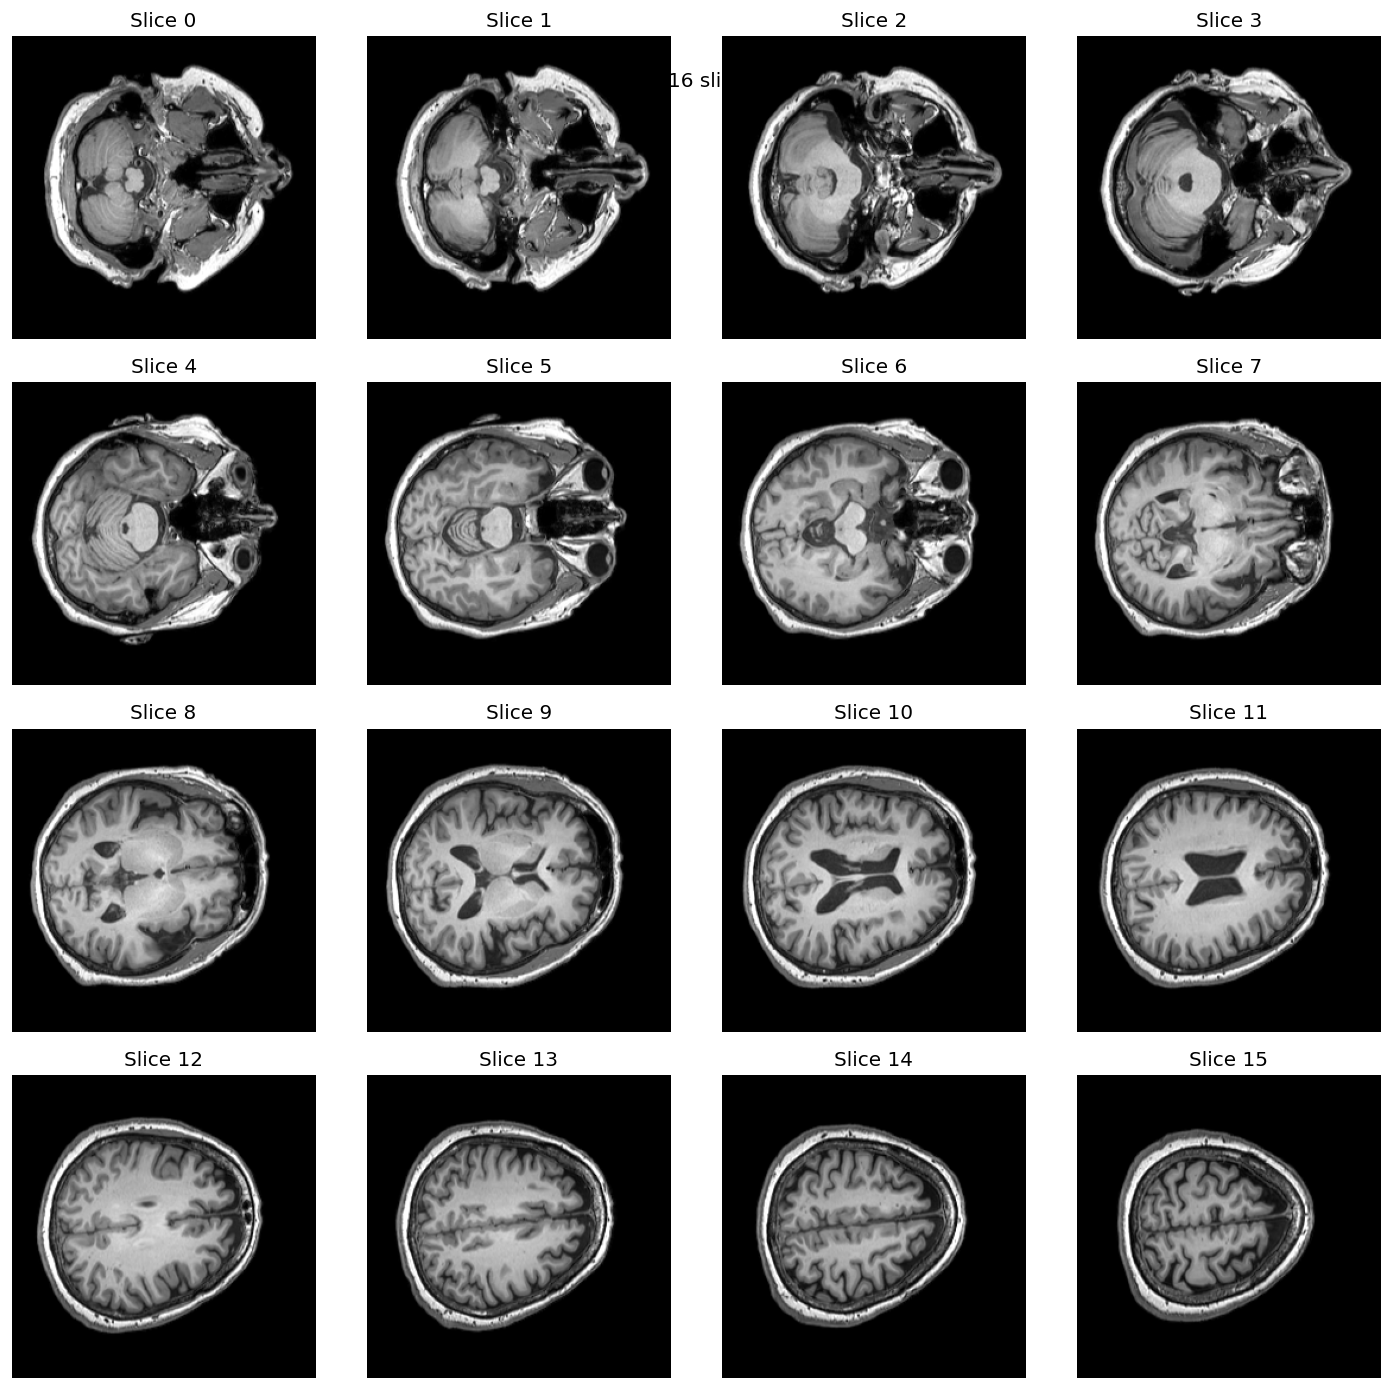

In [24]:
n_slices = volume.shape[0]
n_cols = 4
n_rows = math.ceil(n_slices / n_cols)
vmin, vmax = float(volume.min()), float(volume.max())

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    if idx < n_slices:
        ax.imshow(volume[idx], cmap="gray", vmin=vmin, vmax=vmax)
        ax.set_title(f"Slice {idx}")
    ax.axis("off")
fig.suptitle(f"All {n_slices} slices", y=0.92)
plt.tight_layout()


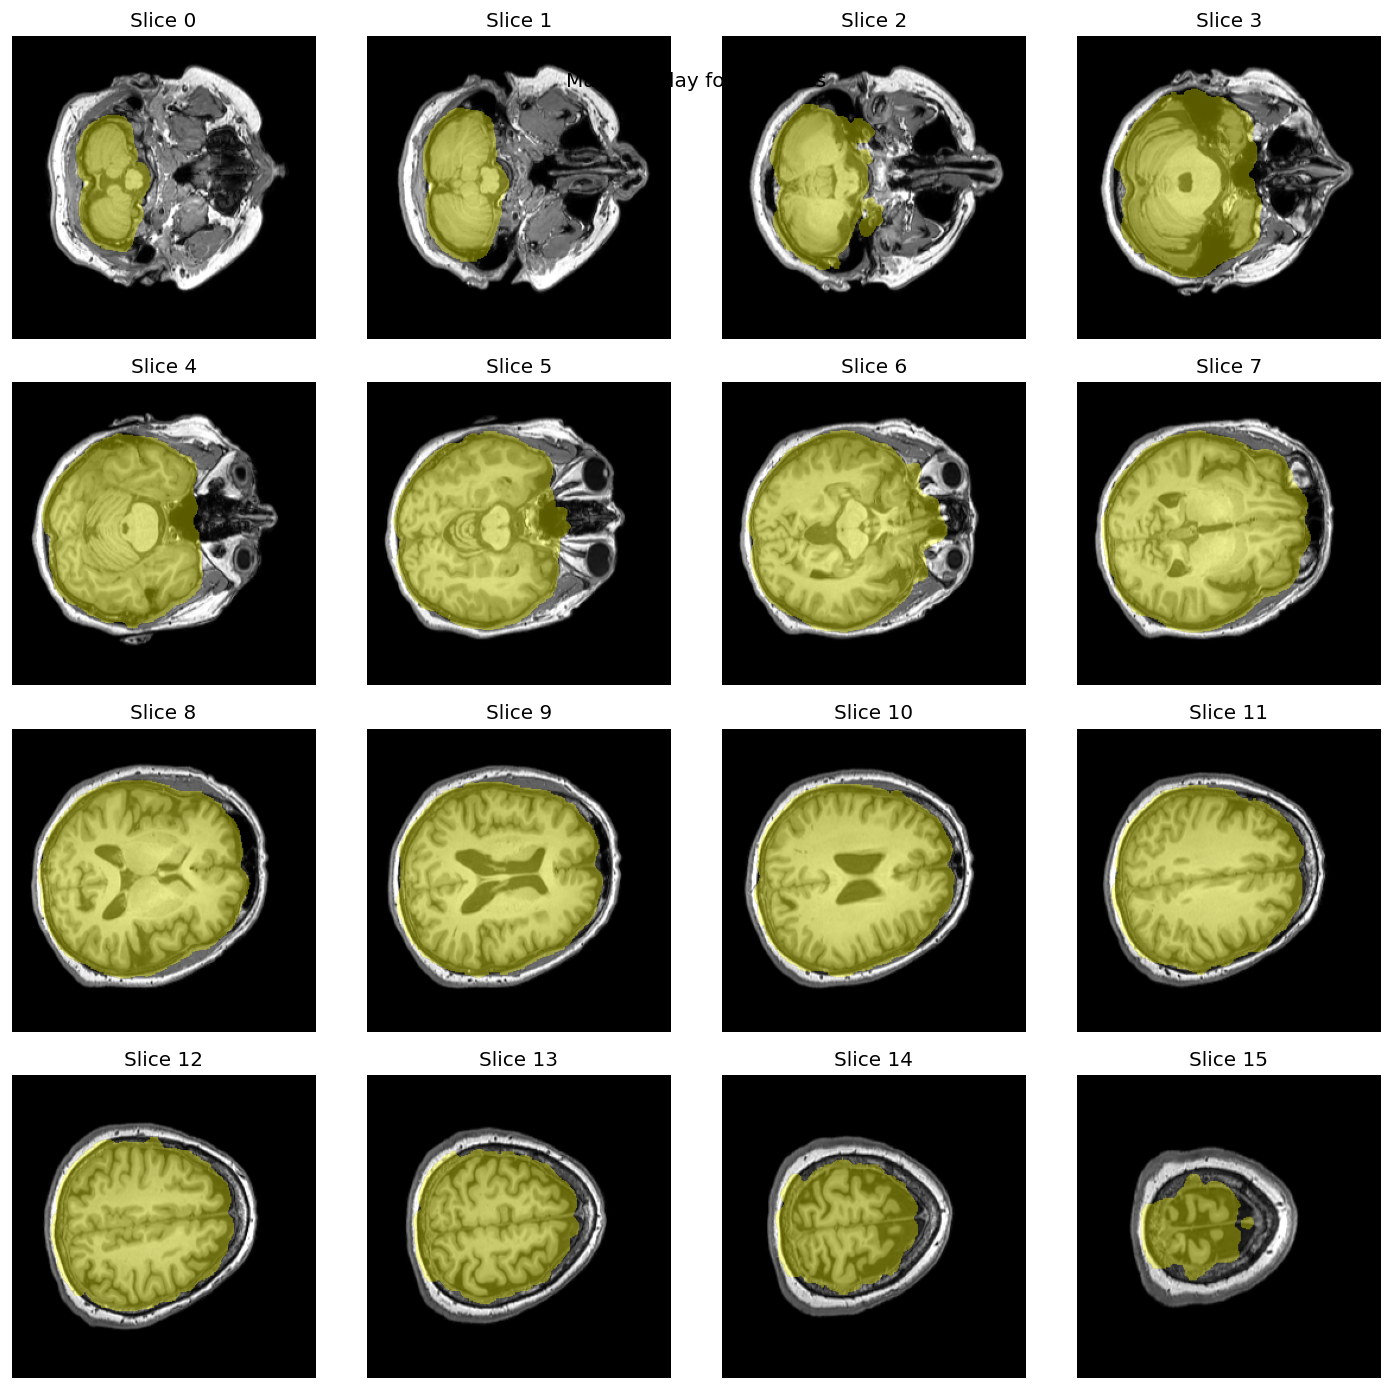

In [8]:
n_slices = volume.shape[0]
n_cols = 4
n_rows = math.ceil(n_slices / n_cols)
vmin, vmax = float(volume.min()), float(volume.max())
overlay_cmap = ListedColormap([[1.0, 1.0, 0.0, 0.6]])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    if idx < n_slices:
        ax.imshow(volume[idx], cmap="gray", vmin=vmin, vmax=vmax)
        mask_overlay = np.ma.masked_where(mask[idx] == 0, mask[idx])
        ax.imshow(mask_overlay, cmap=overlay_cmap, alpha=0.6)
        ax.set_title(f"Slice {idx}")
    ax.axis("off")
fig.suptitle(f"Mask overlay for {n_slices} slices", y=0.92)
plt.tight_layout()


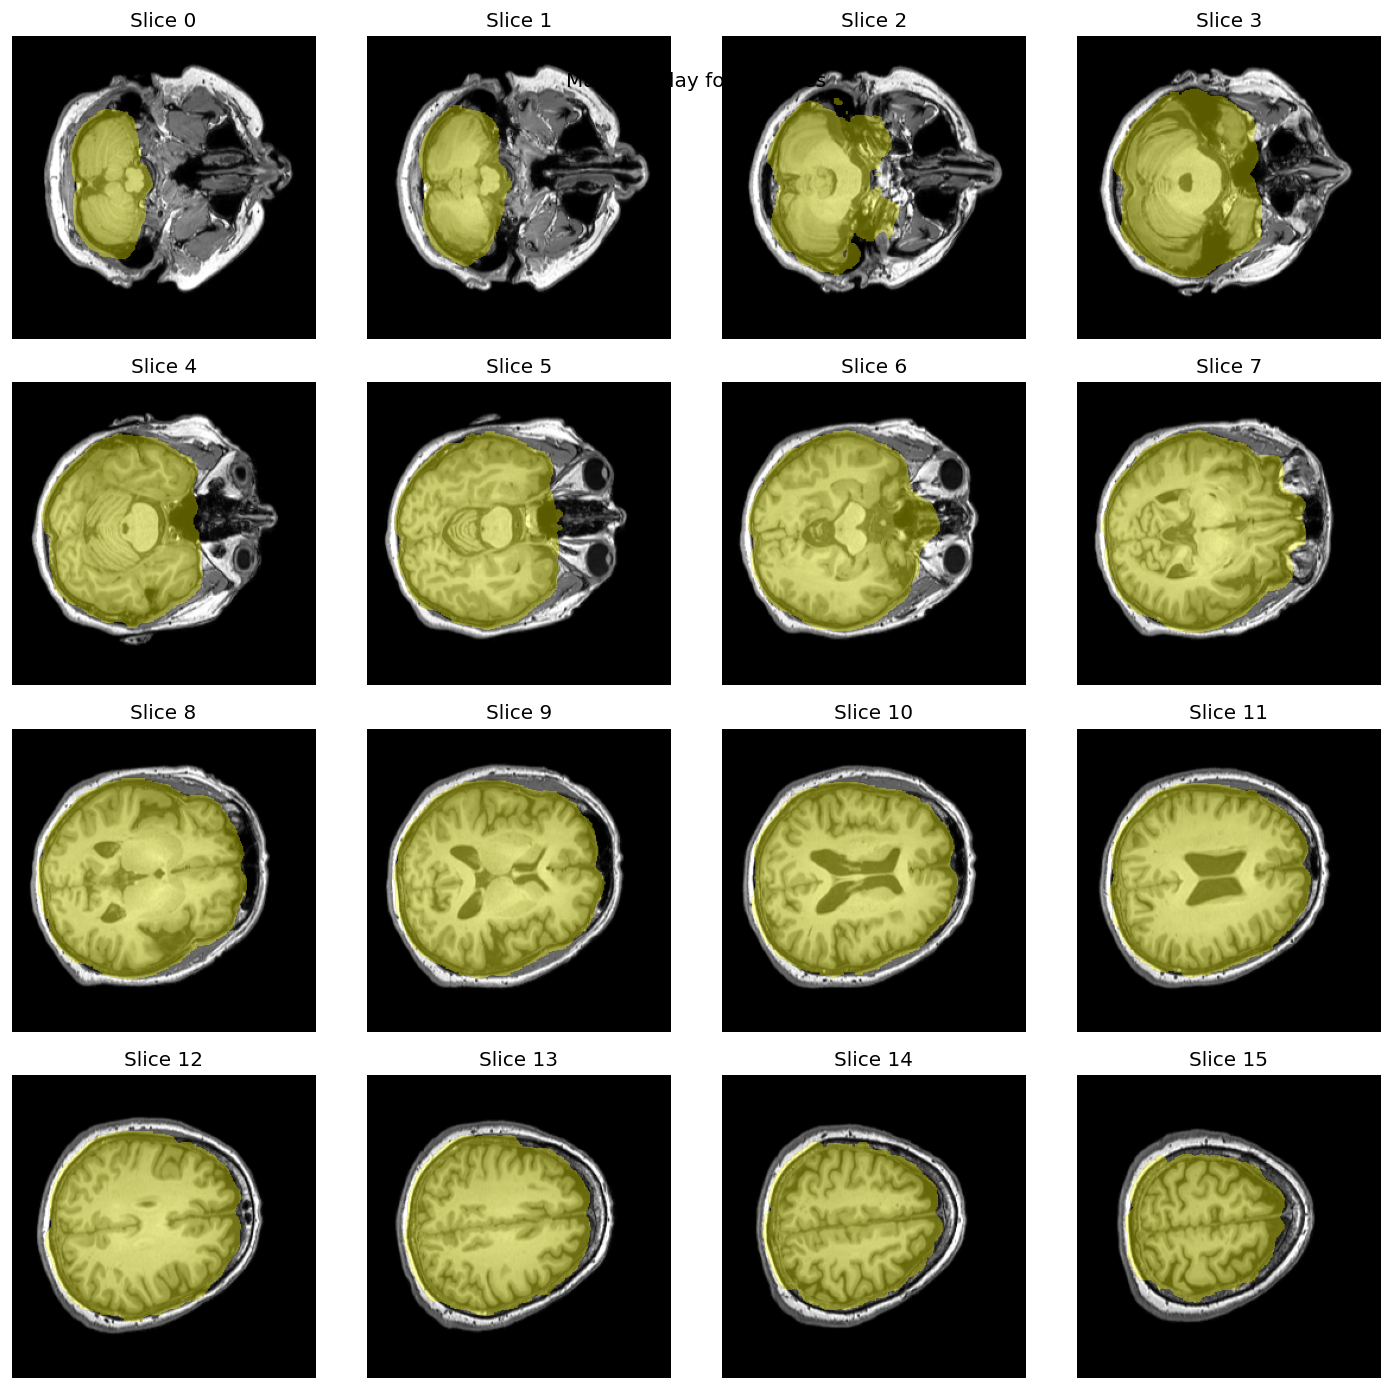

In [25]:
n_slices = volume.shape[0]
n_cols = 4
n_rows = math.ceil(n_slices / n_cols)
vmin, vmax = float(volume.min()), float(volume.max())
overlay_cmap = ListedColormap([[1.0, 1.0, 0.0, 0.6]])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    if idx < n_slices:
        ax.imshow(volume[idx], cmap="gray", vmin=vmin, vmax=vmax)
        mask_overlay = np.ma.masked_where(mask[idx] == 0, mask[idx])
        ax.imshow(mask_overlay, cmap=overlay_cmap, alpha=0.6)
        ax.set_title(f"Slice {idx}")
    ax.axis("off")
fig.suptitle(f"Mask overlay for {n_slices} slices", y=0.92)
plt.tight_layout()
